Jet Nebuliser particle release (jn_ad_mp)
====================================================

### Authors: Ciarraí, James, Miriam, Marco

We try to piece-wise fit the following concentration ODE, which assumes homogeneous mixing.


$$
   \dfrac{dC}{dt} = \dfrac{E}{V}-\lambda C
$$

Where $E$ is the generation rate ($mg/m^3$), $V$ is room volume $m^3$ and $\lambda$ is the removal rate $^{-h}$. This then has a general solution:

$$
C(t)=\dfrac{E}{V\lambda}(1-e^{-\lambda t})+ k e^{-\lambda t}
$$

Where $k$ is the integration constant.

The piece-wise fit is done as follows:

 - for 0<$t$<5 minutes: $C=0.00540826$ (this is the average concentration of the first 5 minutes at 2.0 m across n=5)
 - for 5<$t$<14 minutes: $C = \dfrac{E}{V\lambda }(1-e^{-\lambda t})+ke^{(-\lambda t)}$
 - for 14<$t$<45 minutes: $C = k e^{-\lambda t}$


We need to estimate $E$, $k$ and $\lambda$

In [2]:
# install if not done yet
!pip install pyabc --quiet
#!pip install pyabc[pyarrow]
#import sqlalchemy
#from sqlalchemy import create_engine

In [9]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

import pyabc

from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon
from pyabc.visualization import plot_data_callback, plot_kde_2d

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")

Data
----

We use a data set which consists of a vector of time points $t$
and a measurement vector $data$.  


and the measurement data

In [141]:
import pandas as pd
from datetime import datetime
import numpy as np
data = pd.read_csv('../data/vmn_ad_mp_n=5_2m.txt', sep='\t',header=0) # jn_ad_mp_n=5.txt
data["time"] = data["time"].apply(lambda x: datetime.strptime(x, "%M:%S")) #convert to datetime
data["fraction_of_hour"] = data["time"].apply(lambda x: (x.minute+x.second/60) / 60) #convert to fraction of hour
measurement_data = data['average'] #np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['average']])
measurement_times = data['fraction_of_hour'] #np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['fraction_of_hour']])

# extract data points until 0.5h
#measurement_data = measurement_data[measurement_times <= 0.5]
print(measurement_data)

0      0.007247
1      0.008438
2      0.007403
3      0.009692
4      0.008002
         ...   
130    0.017469
131    0.016520
132    0.017145
133    0.016386
134    0.016599
Name: average, Length: 135, dtype: float64


In [110]:
type(measurement_data)

pandas.core.series.Series

In [5]:
# write data to a txt file
#np.savetxt('jn_ad_mp_clean.txt', np.array([measurement_times, measurement_data]).T, delimiter='\t')

as well as the time points at whith to evaluate

In [139]:
measurement_times = data['fraction_of_hour']

Define the analytical model:

 - for 0<$t$<5 minutes: $C=0.00540826$
 - for 5<$t$<14 minutes: $C = \dfrac{E}{V\lambda }(1-e^{-\lambda t})$
 - for 14<$t$<45 minutes: $C = k e^{-\lambda t}$

In [148]:
def model(param):
    """
    Model function for the piecewise solution.
    
    Parameters
    ----------
    param : dict
        Dictionary containing the values of the parameters E, and lambda.
    t : array-like
        Array of time values.
        
    Returns
    -------
    C : array-like
        Array of concentration values at the given times.
    """
    E = param['E']
    lambda_ = param['lambda_']
    t = measurement_times
    # Initialize empty array for concentration values
    C = np.zeros_like(t)
    V = 38.42
    
    # Loop over time values
    for i, ti in enumerate(t):
        # If time is less than 5 minutes, set concentration to constant value
        if ti < 5/60:
            C[i] = 0.00540826
        # If time is between 5 and 14 minutes, set concentration according to ODE solution
        elif 5/60 <= ti < 14/60:
            C_at_5_minutes = 0.00540826
            C[i] = (E/V)*(1-np.exp(-lambda_*(ti-5/60)))/lambda_ + C_at_5_minutes * np.exp(-lambda_*(ti-5/60))
            C_14=C[i]
        # If time is greater than 14 minutes, set concentration according to decay part
        else:
            C_when_nebulizer_off = C_14
            C[i] = C_when_nebulizer_off * np.exp(-lambda_*(ti-14/60))

    # Add noise to the simulated data
    sigma = 0.001
    C += np.random.normal(0, sigma, size=C.shape)
    # Return the simulated data <0.5h

    return {"Concentration": C}



# An example of the model

Define some example parameters (chosen by eye using a manual piece-wise curve fitting of the VMN_ad_08 file.). For the purpose of this section, I've called them 'true' parameters.

In [153]:
E_true, lambda_true = np.array([10,2.3]) #9.56765, 0.25515, 1.23335

Solve the model for the true parameter values and visualise the results

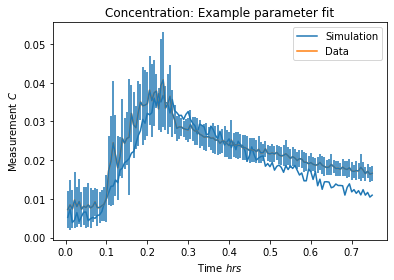

In [154]:
param = {"E": E_true,  "lambda_":lambda_true}
true_trajectory = model(param)["Concentration"]
import matplotlib.pyplot as plt
plt.errorbar(measurement_times,measurement_data,data["stdev"],)
plt.plot(measurement_times,true_trajectory, color="C0", label='Simulation')
plt.plot(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Time $hrs$')
plt.ylabel('Measurement $C$')
plt.title('Concentration: Example parameter fit')
plt.legend()
plt.show()

#np.array(model({'E':3.851195,'k':0.003,'lambda_':1.174})).max()

##Set up the ABC algorithm

Set up the ABC algorithm - we will use the ABC-SMC algorithm
This runs millions of different combinations of parameters and compares the model output to the data. If the distance between the predicted curves and the observed data is 'small enough', then the parameters are accepted. The distance is calculated using the sum of the squared differences between the model and the data.

In [10]:
def distance(simulation, data):
    return (np.absolute((data["Concentration"] - simulation["Concentration"]))).sum()

Define the prior distributions for the parameters. We will use uniform priors for all parameters.

In [129]:
parameter_prior = Distribution(
    E=RV("uniform", 50, 200), lambda_=RV("uniform", 0, 5)
                                )
parameter_prior.get_parameter_names()

['E', 'lambda_']

This is the function that will be called by the ABC algorithm. It takes a set of parameters and returns the distance between the model and the data.

In [155]:
#new distance code
from pyabc.populationstrategy import AdaptivePopulationSize
#from functools import partial
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import QuantileEpsilon

from functools import partial
#PCMAD with Manhattan Distance
scale_log_file_pcmad = tempfile.mkstemp(suffix=".json")[1]

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,
    scale_function=pyabc.distance.pcmad,  # new, previously mad
    scale_log_file=scale_log_file_pcmad,
)

abc = ABCSMC(
    models=model,
    parameter_priors=parameter_prior,
    distance_function=distance_adaptive,
    population_size=AdaptivePopulationSize(start_nr_particles=1000, mean_cv=0.2),
    transitions=LocalTransition(k_fraction=0.3),
    acceptor=pyabc.UniformAcceptor(use_complete_history=True)
)


ABC.Sampler INFO: Parallelize sampling on 8 processes.


This tells the abc model where the experimental data is.

In [143]:
observed_data_np = {"Concentration": measurement_data.to_numpy()}


In [156]:
#abc.new(db_path, {"Concentration": measurement_data, "stdev": data['stdev']}); ordinary distance function
abc.new(db_path, observed_data_np);

ABC.History INFO: Start <ABCSMC id=77, start_time=2023-05-04 13:37:57>


This runs the algorithm

In [157]:
#h = abc.run(minimum_epsilon=0.5, max_nr_populations=10)
h = abc.run(max_nr_populations=25)

ABC INFO: Calibration sample t = -1.
ABC.Distance INFO: Too many high-bias values, correcting only for scale.
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 3.51650112e+02.
ABC INFO: Accepted: 1000 / 1925 = 5.1948e-01, ESS: 1.0000e+03.
ABC.Adaptation INFO: Change nr particles 1000 -> 129
ABC.Distance INFO: Too many high-bias values, correcting only for scale.
ABC INFO: t: 1, eps: 2.40574363e+02.
ABC INFO: Accepted: 129 / 236 = 5.4661e-01, ESS: 1.1850e+02.
ABC.Adaptation INFO: Change nr particles 129 -> 151
ABC.Distance INFO: Too many high-bias values, correcting only for scale.
ABC INFO: t: 2, eps: 3.17485550e+02.
ABC INFO: Accepted: 151 / 344 = 4.3895e-01, ESS: 1.4191e+02.
ABC.Adaptation INFO: Change nr particles 151 -> 171
ABC.Distance INFO: Too many high-bias values, correcting only for scale.
ABC INFO: t: 3, eps: 4.18319437e+02.
ABC INFO: Accepted: 171 / 385 = 4.4416e-01, ESS: 1.4873e+02.
ABC.Adaptation INFO: Change nr particles 171 -> 152
ABC.Dis

Visualization of the probability density functions for $E$and $\lambda$

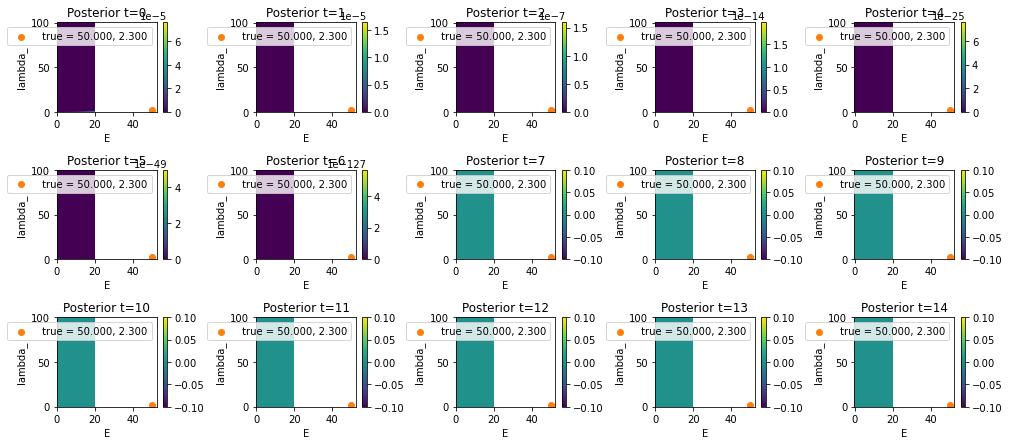

In [123]:
fig = plt.figure(figsize=(14, 12))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(6, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "E",
        "lambda_",
        xmin=0,   #xmin=0
        xmax=20,  #xmax=30
        numx=200, #numx=200
        ymin=0,   #ymin=0
        ymax=100,  #ymax=10
        numy=200, #numy=200
        ax=ax,    #ax=ax
    )
    ax.scatter(
        [E_true],
        [lambda_true],
        color="C1",
        label=r' true = {:.3f}, {:.3f}'.format(
            E_true, lambda_true
        ),
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()
fig.tight_layout()

Plot marginal histograms of the posterior distributions of the three parameters

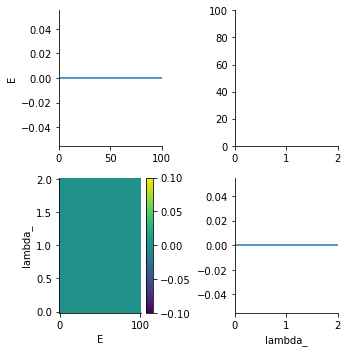

In [147]:
from pyabc.visualization import plot_kde_matrix

limits = dict(E=(0, 100),lambda_=(0, 2))
df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

##We plot a 1000 simulated curves using the posterior distributions of the parameters

We can also plot the simulated trajectories:

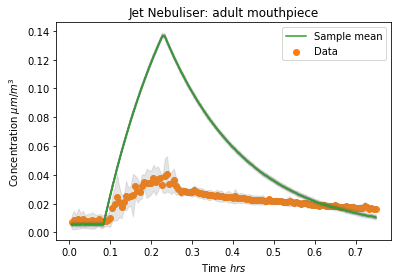

In [158]:
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['Concentration'], color='grey', alpha=0.01)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['Concentration'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

#plt.plot(measurement_times,true_trajectory, color="C0", label='Initial guess')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
#plt.errorbar(measurement_times,measurement_data,yerr=data["stdev"], label ="Data",color='C1')
plt.fill_between(measurement_times, measurement_data - data["stdev"], measurement_data + data["stdev"],color='gray', alpha=0.2)
plt.xlabel('Time $hrs$')
plt.ylabel('Concentration $\mu m/m^3$')
plt.title('Jet Nebuliser: adult mouthpiece')
plt.legend()
plt.show()

# remove stdandard deviation because it penalises central part.
# what about room volume?
# balance data points between each phases
# 

Summary table of parameters

In [120]:
# Create a summary table of parameter values
df, w = h.get_distribution(m=0, t=h.max_t)
df['w'] = w
df = df.sort_values('w', ascending=True)
df = df.reset_index(drop=True)
df = df.round(3)
df.describe()


name,E,k,lambda_,w
count,233.000000,233.000000,233.000000,233.000000
mean,83.823266,0.454674,1.226614,0.004309
std,0.477691,0.268332,0.017230,0.002017
min,82.808000,0.009000,1.189000,0.002000
25%,83.462000,0.217000,1.215000,0.003000
50%,83.793000,0.432000,1.224000,0.004000
75%,84.150000,0.659000,1.238000,0.005000
max,84.837000,0.991000,1.264000,0.015000
